In [32]:
import numpy as np
import pandas as pd
import math
import scipy.io
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#loading regression methods
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression as lor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression as lr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svc
from sklearn.svm import NuSVC as nusvc
from sklearn.svm import LinearSVC as lsvc
from sklearn.svm import LinearSVR as lsvr
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import seaborn as sns

In [2]:
geno = pd.read_csv('geno50.csv')
geno =  geno.drop('ChemoResponse',axis = 1)
meta = pd.read_csv("meta_processed.csv")
meta["DRFS_Year"] = meta["DRFS_Year"].fillna("unknown")

In [30]:
meta

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year,ChemoEncoding
0,44.0,positive,positive,negative,2.0,T3,N0,unknown,unknown,unknown,0
1,43.0,positive,positive,negative,unknown,T4,N1,unknown,unknown,unknown,0
2,56.0,negative,negative,negative,3,T4,N3,unknown,unknown,cat1,0
3,41.0,positive,negative,negative,2,T2,N1,unknown,unknown,cat3,0
4,39.0,positive,positive,negative,3.0,T2,N1,unknown,unknown,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
1166,46.0,negative,negative,positive,3.0,T3,unknown,unknown,unknown,unknown,1
1167,62.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat1,0
1168,44.0,positive,negative,negative,2.0,T2,unknown,unknown,unknown,unknown,0
1169,38.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat3,0


In [3]:
def train_test_dev_split(X_concat,meta):
    if(type(X_concat) != type(pd.DataFrame())):
        X_concat = pd.DataFrame(X_concat)
    pos_index = meta.index[meta['ChemoEncoding'] == 1].values
    neg_index = meta.index[meta['ChemoEncoding'] == 0].values
    
    n_pos, n_neg = pos_index.shape[0], neg_index.shape[0]

    rng = np.random.default_rng(37)
    rng.shuffle(pos_index)
    rng.shuffle(neg_index)


    train_idx_pos, train_idx_neg = int(n_pos*0.8), int(n_neg* 0.8)
    test_idx_pos, test_idx_neg = train_idx_pos + int(n_pos*0.1), train_idx_neg + int(n_neg*0.1)
    dev_idx_pos, dev_idx_neg = test_idx_pos, test_idx_neg


    train_idx = np.r_[pos_index[:train_idx_pos], neg_index[:train_idx_neg] ]
    test_idx = np.r_[pos_index[train_idx_pos:test_idx_pos], neg_index[train_idx_neg:test_idx_neg]]
    dev_idx = np.r_[pos_index[test_idx_pos:], neg_index[test_idx_neg:]]
    print(f'train_idx:{train_idx.shape[0]}')
    print(f'test_idx:{test_idx.shape[0]}')
    print(f'dec_idx:{dev_idx.shape[0]}')
    
    X_train, y_train = X_concat.iloc[train_idx,:], meta.iloc[train_idx,:]['ChemoEncoding']
    X_test, y_test = X_concat.iloc[test_idx,:], meta.iloc[test_idx,:]['ChemoEncoding']
    X_dev, y_dev = X_concat.iloc[dev_idx,:], meta.iloc[dev_idx,:]['ChemoEncoding']
    
    return (X_train,y_train), (X_test,y_test), (X_dev,y_dev)

In [4]:
def get_geno_concat(geno, meta):
    X = meta.drop('ChemoEncoding', axis=1)
    X_new = pd.concat([X, geno],axis= 1)
    contious_cols = X_new[list(geno.columns) + ['Age']]
    X_categorical = X_new.drop(list(geno.columns) + ['Age'], axis=1)
    # apply one-hot encoding to the categorical features
    X_cate_OH = pd.get_dummies(X_categorical)
    X_new_OH = pd.concat([contious_cols,  X_cate_OH], axis=1)
    
    return X_new_OH

### Train Test split

In [5]:
# X and Y train are for traning 
# X and Y test are for picking algothrims and tuning paramters 
# X and Y dev are only used when we pick our final model and check for performances
X_concat = get_geno_concat(geno, meta)
train_set, test_set, dev_set = train_test_dev_split(X_concat, meta)
X_train, y_train = train_set
X_test, y_test = test_set
X_dev, y_dev = dev_set

train_idx:936
test_idx:116
dec_idx:119


### Apply models 

In [37]:
model=[lda(),qda(),gnb(),rf(),svc(),lsvc(),knn(),lor(),xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17),AdaBoostClassifier(n_estimators=100, random_state=17)]
print('a','model')
for i in model:
    clf=i.fit(X_train,y_train)
    a=accuracy_score(y_test, clf.predict(X_test))
    print(a,i)

a model
0.8448275862068966 LinearDiscriminantAnalysis()
0.2413793103448276 QuadraticDiscriminantAnalysis()
0.603448275862069 GaussianNB()
0.8275862068965517 RandomForestClassifier()
0.8017241379310345 SVC()
0.8189655172413793 LinearSVC()
0.7931034482758621 KNeighborsClassifier()
0.8362068965517241 LogisticRegression()
0.8793103448275862 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_j

#### Rough look:
We pick random forest, ada boosting, XG boosting to look for further results. 

### Random Forest

In [7]:
# Random Forest + k-fold validation to find best AUC    
depth = [1,3,5,10,20,30]
n_splits = 10
ACC = []
AUC = []
for i in range(len(depth)):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rfc = RandomForestClassifier(n_estimators=100, random_state=20, max_depth = depth[i])
    Acc = []
    Auc = []
    for train_index, test_index in kf.split(X_train,y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        

        rfc.fit(X_fold_train, y_fold_train)
        y_pred = rfc.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        # append
        Acc.append(acc)
        Auc.append(auc)
    ACC.append(sum(Acc) / n_splits)
    AUC.append(sum(Auc) / n_splits)
    print("Mean accuracy score: ", ACC[i],"at depth: ",depth[i])
    print("Mean auc score: ", AUC[i],"at depth: ",depth[i])
print("Best auc occur at idex: ", np.argmax(AUC), "depth is: ",depth[np.argmax(AUC)], "AUC is:", AUC[np.argmax(AUC)])

Mean accuracy score:  0.8017241379310345 at depth:  1
Mean auc score:  0.5 at depth:  1
Mean accuracy score:  0.814655172413793 at depth:  3
Mean auc score:  0.5375175315568022 at depth:  3
Mean accuracy score:  0.8318965517241379 at depth:  5
Mean auc score:  0.602267414679757 at depth:  5
Mean accuracy score:  0.8362068965517242 at depth:  10
Mean auc score:  0.6262272089761571 at depth:  10
Mean accuracy score:  0.838793103448276 at depth:  20
Mean auc score:  0.6409303412809725 at depth:  20
Mean accuracy score:  0.8387931034482758 at depth:  30
Mean auc score:  0.6425666199158486 at depth:  30
Best auc occur at idex:  5 depth is:  30 AUC is: 0.6425666199158486


In [8]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
depth = [1,3,5,10,20,30]
def testRandomForest(X_train, y_train, X_test, y_test):
    SEN = []
    SPC = []
    ACC = []
    AUC = []
    for i in range(len(depth)):
        model = RandomForestClassifier(n_estimators=100, random_state=17,max_depth=depth[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        # append
        ACC.append(acc)
        AUC.append(auc)
        SEN.append(sensitivity)
        SPC.append(specificity)
    return ACC,AUC,SEN,SPC

In [9]:
acc, auc, sen,spc = testRandomForest(X_train, y_train, X_test, y_test)
print(depth)
print(sen)
print(spc)

[1, 3, 5, 10, 20, 30]
[0.0, 0.04, 0.2, 0.24, 0.24, 0.24]
[1.0, 0.9893617021276596, 1.0, 0.9787234042553191, 0.9893617021276596, 0.9787234042553191]


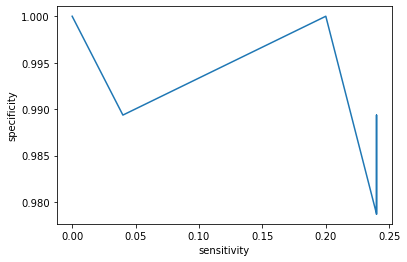

In [10]:
# sensitivity vs. specificity
plt.plot(sen,spc)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.show()

0.8319327731092437


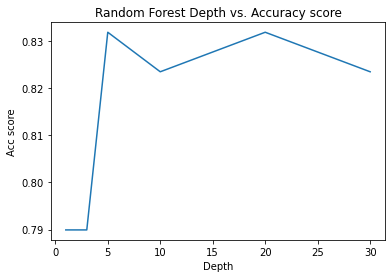

In [11]:
# check test accuracy 
print(max(acc))
plt.plot(depth,acc)
plt.xlabel('Depth')
plt.ylabel('Acc score')
plt.title('Random Forest Depth vs. Accuracy score')
plt.show()

0.6146808510638299


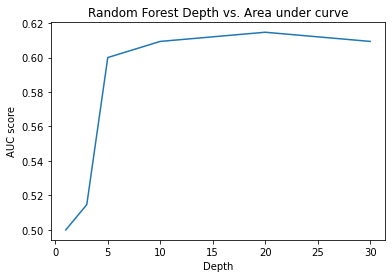

In [12]:
# check auc score
print(max(auc))
plt.plot(depth,auc)
plt.xlabel('Depth')
plt.ylabel('AUC score')
plt.title('Random Forest Depth vs. Area under curve')
plt.show()

### Check ROC and Confusion Matrix

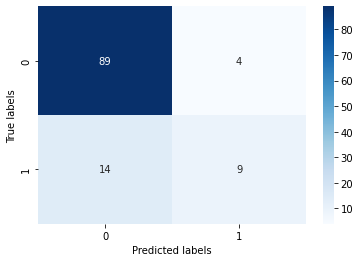

In [43]:
# train best parameter generated by k-fold
model = RandomForestClassifier(n_estimators=100, random_state=17,max_depth=30)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [47]:
def plot_roc_curve(y_pred, y_test):
    fpr, tpr, _ = roc_curve(y_pred, y_test)
    roc_auc = roc_auc_score(y_pred, y_test)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

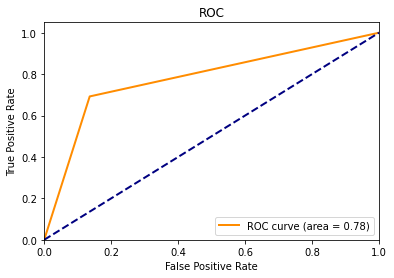

In [48]:
plot_roc_curve(y_pred, y_test)

### XG bossting and K-fold 

In [13]:
# XGboosting
depth = [1,3,5,10,20,30]
n_splits = 10
ACC = []
AUC = []
for i in range(len(depth)):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=17, max_depth=depth[i])
    Acc = []
    Auc = []
    for train_index, test_index in kf.split(X_train,y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index], 
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        xgb_clf.fit(X_fold_train, y_fold_train)
        y_pred = xgb_clf.predict(X_fold_test)
        auc = roc_auc_score(y_fold_test, y_pred)
        acc = accuracy_score(y_fold_test, y_pred)
        # append
        Acc.append(acc)
        Auc.append(auc)
    ACC.append(sum(Acc) / n_splits)
    AUC.append(sum(Auc) / n_splits)
    print("Mean accuracy score: ", ACC[i],"at depth: ",depth[i])
    print("Mean auc score: ", AUC[i],"at depth: ",depth[i])
print("Best auc occur at index: ", np.argmax(AUC), "depth is: ",depth[np.argmax(AUC)], "AUC is:", AUC[np.argmax(AUC)])


Mean accuracy score:  0.8034202699611074 at depth:  1
Mean auc score:  0.6060403034613562 at depth:  1
Mean accuracy score:  0.793845801876001 at depth:  3
Mean auc score:  0.6098288288288288 at depth:  3
Mean accuracy score:  0.8002402196293754 at depth:  5
Mean auc score:  0.6295301090564248 at depth:  5
Mean accuracy score:  0.815168153740563 at depth:  10
Mean auc score:  0.6251541014698909 at depth:  10
Mean accuracy score:  0.8077213452299246 at depth:  20
Mean auc score:  0.6165486012328119 at depth:  20
Mean accuracy score:  0.8077213452299246 at depth:  30
Mean auc score:  0.6165486012328119 at depth:  30
Best auc occur at index:  2 depth is:  5 AUC is: 0.6295301090564248


In [14]:
# XG boosting and just check AUC score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

depth = [1,3,5,10,20,30]

def testXGBoost(X_train, y_train, X_test, y_test):
    SEN = []
    SPC = []
    ACC = []
    AUC = []
    for i in range(len(depth)):
        model = xgb.XGBClassifier(n_estimators=100, random_state=17, max_depth=depth[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        # append
        ACC.append(acc)
        AUC.append(auc)
        SEN.append(sensitivity)
        SPC.append(specificity)
    return ACC, AUC, SEN, SPC

acc,auc,sen,spc = testXGBoost(X_train, y_train, X_test, y_test)

[0.4782608695652174, 0.43478260869565216, 0.5217391304347826, 0.4782608695652174, 0.391304347826087, 0.391304347826087]
[0.946236559139785, 0.967741935483871, 0.967741935483871, 0.978494623655914, 0.956989247311828, 0.956989247311828]


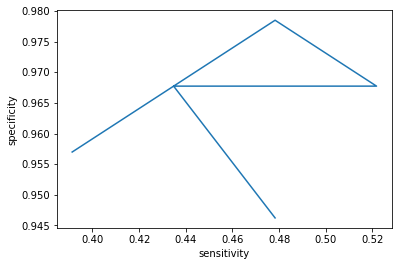

In [15]:
# sensitivity vs. specificity
print(sen)
print(spc)
plt.plot(sen,spc)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.show()

0.7447405329593269


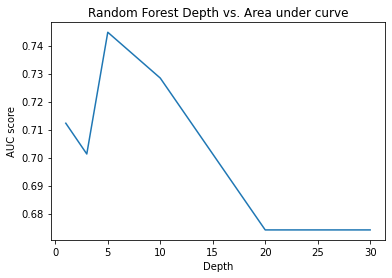

In [16]:
# check auc score
print(max(auc))
plt.plot(depth,auc)
plt.xlabel('Depth')
plt.ylabel('AUC score')
plt.title('Random Forest Depth vs. Area under curve')
plt.show()

0.8793103448275862


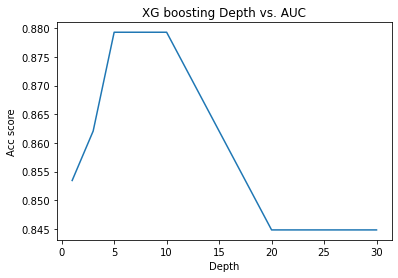

In [17]:
# check test accuracy 
print(max(acc))
plt.plot(depth,acc)
plt.xlabel('Depth')
plt.ylabel('Acc score')
plt.title('XG boosting Depth vs. AUC')
plt.show()

### ROC and confusion matrix for XG

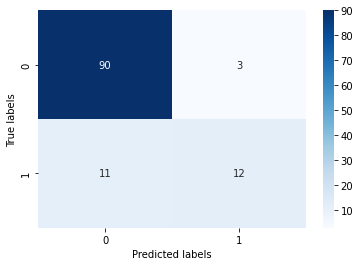

In [49]:
# train best parameter generated by k-fold
model = xgb.XGBClassifier(n_estimators=100, random_state=17, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

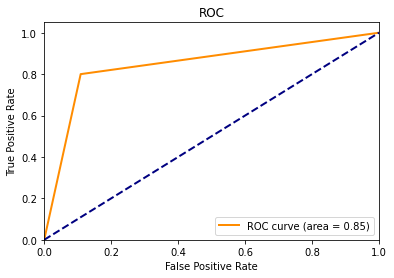

In [50]:
plot_roc_curve(y_pred, y_test)

### Adaboosting 

In [18]:
# ada boosting
def testAda(X_train, y_train, X_test, y_test):
    AUC = []
    SEN = []
    SPC = []
   
    model = AdaBoostClassifier(n_estimators=100, random_state=17)
    model.fit(X_train, y_train)
    
    y_scores = model.predict_proba(X_test)[:,1]
    y_pred = (y_scores > 0.4944444).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    acc = accuracy_score(y_pred,y_test)
    auc = roc_auc_score(y_pred,y_test)
    return acc,auc,sensitivity,specificity
acc,auc,sen,spc = testAda(X_train, y_train, X_test, y_test)
print("Accuracy:",acc)
print("AUC:", auc)
print("Sensitivity:", sen)
print("Specificity:", spc)

Accuracy: 0.7327586206896551
AUC: 0.6698232323232324
Sensitivity: 0.782608695652174
Specificity: 0.7204301075268817


### ROC and confusion matrix for ADA boosting

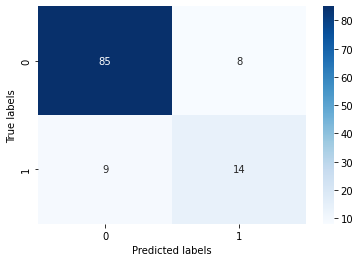

In [52]:
# train best parameter generated by k-fold
model = AdaBoostClassifier(n_estimators=100, random_state=17)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

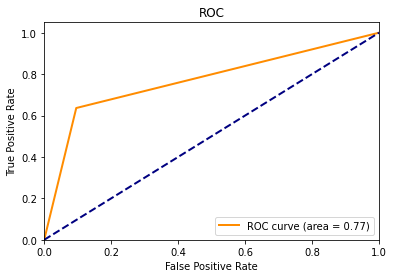

In [53]:
plot_roc_curve(y_pred, y_test)

### Voting Classifier

In [23]:
# voting classifier
# create the base models
rf = RandomForestClassifier(max_depth=30, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_test)[:, 1]

# compute the evaluation metrics
auc = roc_auc_score(y_test, y_pred_proba)
y_pred = [1 if prob >= 0.3 else 0 for prob in y_pred_proba]
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)



AUC score:  0.9018232819074333
Accuracy score:  0.8448275862068966
Sensitivity:  0.782608695652174
Specificity:  0.8602150537634409


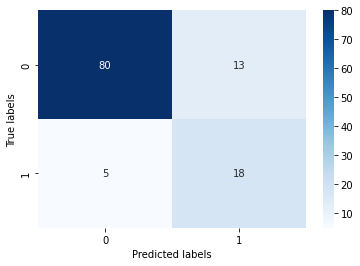

In [54]:
# train best parameter generated by k-fold
rf = RandomForestClassifier(max_depth=30, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')
voting.fit(X_train, y_train)
y_pred_proba = voting.predict_proba(X_test)[:, 1]
y_pred = [1 if prob >= 0.3 else 0 for prob in y_pred_proba]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

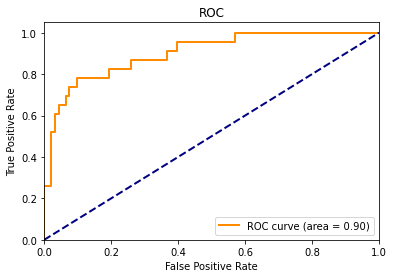

In [56]:
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(y_test, y_pred_proba)

### Choose best threshold for voting

In [27]:
# voting
# create the base models
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_test)[:, 1]

# optimize the threshold for y_pred using a custom score function
best_threshold = None
best_score = None
for threshold in np.arange(0, 1.01, 0.01):
    y_pred = [1 if prob >= threshold else 0 for prob in y_pred_proba]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    score = 1*sensitivity + specificity
    if best_score is None or score > best_score:
        best_score = score
        best_threshold = threshold

# compute the evaluation metrics using the optimized threshold
y_pred = [1 if prob >= best_threshold else 0 for prob in y_pred_proba]
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Optimized threshold: ", best_threshold)


AUC score:  0.9060308555399719
Accuracy score:  0.8620689655172413
Sensitivity:  0.782608695652174
Specificity:  0.8817204301075269
Optimized threshold:  0.3


In [28]:
best_threshold

0.3

### Test test set on Voting Algorithm

In [29]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# create the base models
rf = RandomForestClassifier(max_depth=30, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_dev)[:, 1]

# compute the evaluation metrics
auc = roc_auc_score(y_dev, y_pred_proba)
y_pred = [1 if prob >= 0.3 else 0 for prob in y_pred_proba]
acc = accuracy_score(y_dev, y_pred)
tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)



AUC score:  0.8570212765957446
Accuracy score:  0.8235294117647058
Sensitivity:  0.72
Specificity:  0.851063829787234


### Check ROC and Confusion Matrix for Voting on Dev set

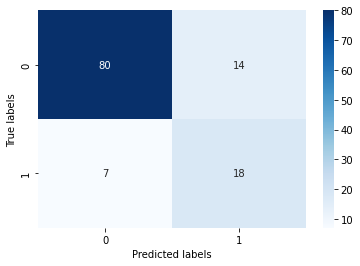

In [58]:
# train best parameter generated by k-fold
rf = RandomForestClassifier(max_depth=30, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')
voting.fit(X_train, y_train)
y_pred_proba = voting.predict_proba(X_dev)[:, 1]
y_pred = [1 if prob >= 0.3 else 0 for prob in y_pred_proba]

# Compute confusion matrix
cm = confusion_matrix(y_dev, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

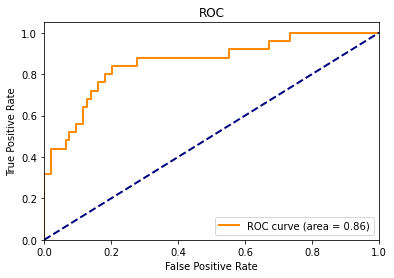

In [59]:
plot_roc_curve(y_dev, y_pred_proba)

### other stuff

0.000000 0.000000 1.720093
0.000000 0.040000 0.720093
0.000000 0.320000 0.614127
0.021277 0.320000 0.593239
0.021277 0.440000 0.480221
0.063830 0.440000 0.436212
0.063830 0.480000 0.433418
0.074468 0.480000 0.424516
0.074468 0.520000 0.397988
0.095745 0.520000 0.392565
0.095745 0.560000 0.360670
0.117021 0.560000 0.334235
0.117021 0.640000 0.325141
0.127660 0.640000 0.321679
0.127660 0.680000 0.313535
0.138298 0.680000 0.308192
0.138298 0.720000 0.307882
0.159574 0.720000 0.299321
0.159574 0.760000 0.298803
0.180851 0.760000 0.295328
0.180851 0.800000 0.293160
0.202128 0.800000 0.275999
0.202128 0.840000 0.274268
0.276596 0.840000 0.248361
0.276596 0.880000 0.248142
0.553191 0.880000 0.200846
0.553191 0.920000 0.197809
0.670213 0.920000 0.187608
0.670213 0.960000 0.186319
0.734043 0.960000 0.180435
0.734043 1.000000 0.180127
1.000000 1.000000 0.115324


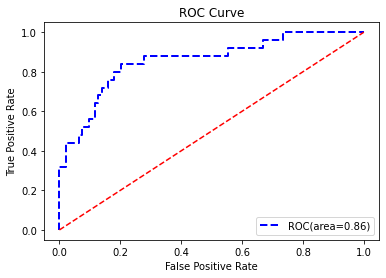

In [31]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

model = voting
prob_test = model.predict_proba(X_dev)
predict_test_value = prob_test[:, 1]
fpr,tpr,thersholds=roc_curve(y_dev,predict_test_value)
#fpr,tpr,thersholds=roc_curve(Y_test,model.predict(X_test))

for i,value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i],tpr[i],value))
roc_auc=auc(fpr,tpr)
plt.plot(fpr,tpr,'b--',label='ROC(area={0:.2f})'.format(roc_auc),lw=2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], "r--")
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()